In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from bernoullimix import BernoulliMixture, random_mixture_generator

In [3]:
import sklearn.datasets

In [4]:
digits_dataset = sklearn.datasets.load_digits()

In [5]:
digits_dataset.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
digits = pd.DataFrame(digits_dataset.data)
labels = pd.Series(digits_dataset.target, index=digits.index)

In [7]:
binary_digits = digits > 0

/Users/saulius/.virtualenvs/scientific-py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


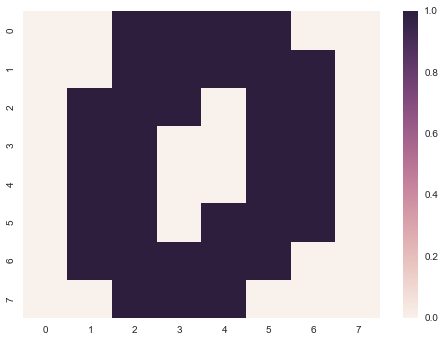

In [8]:
sns.heatmap(binary_digits.iloc[0].reshape(8, 8))

In [9]:
K=10
D=64
RANDOM_STATE = 1208

In [10]:
N_MIXTURES_TO_FIT = 100

In [11]:
generator = random_mixture_generator(K, binary_digits, random_state=RANDOM_STATE)

In [12]:
import itertools
mixtures = list(itertools.islice(generator, N_MIXTURES_TO_FIT))

In [13]:
CONVERGENCE_THRESHOLD = np.finfo(np.float64).eps

In [27]:
print(np.array_repr(mixtures[25].mixing_coefficients, precision=15))

array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1])


In [23]:
print(np.array_repr(mixtures[25].emission_probabilities, precision=28))

array([[ 0.6978965760488041736309128282,  0.7036115683958358291150148034,
         0.6380317721696751043225503963,  0.8409544989363169076312942707,
         0.3007875795115599326656763424,  0.0758594723484237870581026186,
         0.6975389262088884656520804128,  0.4288022388673252693891413401,
         0.1633572298120198051929463645,  0.443589323876154462134024925 ,
         0.93704245782286998966981173  ,  0.2537696125567985294679829167,
         0.7351703721577219630134436557,  0.6567200377856511339658140969,
         0.0721740188950653754895725456,  0.0628624857690395916209880056,
         0.0447333084958508875317306774,  0.716702920704979207222606874 ,
         0.9170963138325006758222457393,  0.681738458316486828358904404 ,
         0.7139602172549748271279668188,  0.5325532481131333151225248912,
         0.1731785867012543278509184574,  0.3364778681351496825158164938,
         0.2203332187830309707443632306,  0.6211229011457480853053425562,
         0.936560625512377398216301571

In [25]:
np.finfo(np.float128).precision

18

In [ ]:
%%time
convergences = []
lls = []
for i, mixture in enumerate(mixtures):
    try:
        ll, convergence = mixture.fit(binary_digits, iteration_limit=None, convergence_threshold=CONVERGENCE_THRESHOLD)
    except Exception:
        print('Failed mixture: {}'.format(i))
        raise
    convergences.append(convergence)
    lls.append(ll)

In [ ]:
mixture

In [ ]:
lls = pd.Series(lls)

In [ ]:
best_mixture = mixtures[lls.argmax()]

In [ ]:
best_mcs = pd.Series(best_mixture.mixing_coefficients)
best_eps = pd.DataFrame(best_mixture.emission_probabilities, index=best_mcs.index, columns=binary_digits.columns)

In [ ]:
best_mcs = best_mcs.sort_values(ascending=False)
best_eps = best_eps.loc[best_mcs.index]

In [ ]:
plt.figure(figsize=(20, 20))
ax = plt.gca()
for i in range(K):
    ax = plt.subplot(4, 3, i+1)
    sns.heatmap(best_eps.iloc[i].reshape(8, 8), vmin=0, vmax=1, ax=ax, square=True)
    plt.title('Component {} ({:.2%})'.format(i, best_mcs.iloc[i]))
    

In [ ]:
binary_digits_with_random_noise = binary_digits.copy()
NOISE_PROB = 0.3
random = np.random.RandomState(RANDOM_STATE)

noise_mask = pd.DataFrame(random.binomial(1, NOISE_PROB, size=binary_digits_with_random_noise.shape),
                          index=binary_digits_with_random_noise.index,
                          columns=binary_digits_with_random_noise.columns,
                          dtype=bool)


binary_digits_with_random_noise[noise_mask] = None


In [ ]:
binary_digits_with_random_noise

In [ ]:
generator_noise = random_mixture_generator(K, binary_digits_with_random_noise, random_state=RANDOM_STATE)
mixtures_noise = list(itertools.islice(generator_noise, N_MIXTURES_TO_FIT))

In [ ]:
%%time
convergences_noise = []
lls_noise = []
for mixture in mixtures_noise:
    ll, convergence = mixture.fit(binary_digits_with_random_noise, 
                                  iteration_limit=None, 
                                  convergence_threshold=CONVERGENCE_THRESHOLD)
    convergences_noise.append(convergence)
    lls_noise.append(ll)

In [ ]:
lls_noise = pd.Series(lls_noise)
best_mixture_noise = mixtures_noise[lls_noise.argmax()]

In [ ]:
best_mcs_noise = pd.Series(best_mixture_noise.mixing_coefficients)
best_eps_noise = pd.DataFrame(best_mixture_noise.emission_probabilities, 
                              index=best_mcs_noise.index, columns=binary_digits_with_random_noise.columns)

In [ ]:
best_mcs_noise = best_mcs_noise.sort_values(ascending=False)
best_eps_noise = best_eps_noise.loc[best_mcs_noise.index]

In [ ]:
plt.figure(figsize=(20, 20))
ax = plt.gca()
for i in range(K):
    ax = plt.subplot(4, 3, i+1)
    sns.heatmap(best_eps_noise.iloc[i].reshape(8, 8), vmin=0, vmax=1, ax=ax, square=True)
    plt.title('Component {} ({:.2%})'.format(i, best_mcs_noise.iloc[i]))
    

In [ ]:
_means = binary_digits.groupby(labels).mean()
_counts = labels.value_counts() / len(labels)

_means = _means.loc[_counts.index]
plt.figure(figsize=(20, 20))
ax = plt.gca()
for i, (ix, row) in enumerate(_means.iterrows()):
    ax = plt.subplot(4, 3, i+1)
    sns.heatmap(row.reshape(8, 8), vmin=0, vmax=1, ax=ax, square=True)
    plt.title('{} ({:.2%})'.format(ix, _counts.loc[ix]))
    
    

In [ ]:
_means = binary_digits_with_random_noise.groupby(labels).mean()
_counts = labels.value_counts() / len(labels)

_means = _means.loc[_counts.index]
plt.figure(figsize=(20, 20))
ax = plt.gca()
for i, (ix, row) in enumerate(_means.iterrows()):
    ax = plt.subplot(4, 3, i+1)
    sns.heatmap(row.reshape(8, 8), vmin=0, vmax=1, ax=ax, square=True)
    plt.title('{} ({:.2%})'.format(ix, _counts.loc[ix]))
    
    